# Final model

Techniques used:
* Transfer learning: use ResNet50 pre-trained on ImageNet plus some dense layers with dropout and batch normalization
* Data augmentation on training using Keras' ImageDataGenerator
* Train using Focal Loss
* Reduce LR on plateau and early stopping
* K-fold cross-validation grouping by WSI
* Test time augmentation

This notebook preprocess the images for training, defines and trains a model, and creates a submission.

In [36]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf

from keras.applications.resnet50 import ResNet50, preprocess_input
# from classification_models.resnet import ResNet18, preprocess_input
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold

In [2]:
# Configure Keras and TensorFlow so that they use the GPU
tf_config = tf.ConfigProto(allow_soft_placement=True)
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
K.set_session(sess)

## Read images and labels

In [3]:
data_path = os.path.join(os.getcwd(), 'input')

In [4]:
train_path = os.path.join(data_path, 'train')
labels_path = os.path.join(data_path, 'train_labels.csv')

In [5]:
df = pd.read_csv(labels_path)
# df = df.head(1000)  # Remove this line for full data
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
def crop_roi(img, roi_size=48):
    """Crop a square region in the center of the image."""
    size = img.shape[0]
    roi_ul = (int(size / 2 - roi_size / 2), int(size / 2 - roi_size / 2))
    roi_lr = (int(size / 2 + roi_size / 2), int(size / 2 + roi_size / 2))
    return img[roi_ul[1]: roi_lr[1], roi_ul[0]: roi_lr[0]]

def load_image(img_id, img_size=96, roi_size=None):
    """Load image using its id. Resize and crop is optional."""
    img_path = os.path.join(train_path, '{}.tif'.format(img_id))
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    if roi_size:
        return crop_roi(img, roi_size)
    return img

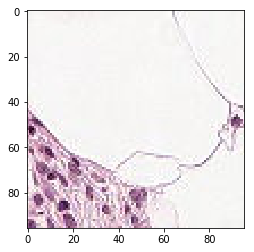

In [7]:
img = load_image(df.id[0])
plt.imshow(img / 255)

## Load WSIs per Image Id

Thanks to this [Kaggle discussion](https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/83760), we can see that images in the data are taken from a larger *Whole slide image* (WSI). If we split these sections between train and validation we could overestimate the validation metric.

In [8]:
wsi_path = os.path.join(data_path, 'patch_id_wsi.csv')
df = df.merge(pd.read_csv(wsi_path), left_on='id', right_on='id', how='left')

Now let's obtain the WSI per image if available to make a proper split afterwards.

In [9]:
df.wsi = df.wsi.str.split("_", expand=True)[3]

For the ids that aren't associated with a WSI, use a random value:

In [10]:
df.wsi.fillna(np.random.choice(df[pd.notnull(df.wsi)].wsi.values), inplace=True)

## Load and preprocess train set

Let's load all the images and annotations and pickle the results. For future reference the following format is used for pickled names:

`train_images_[img_size]_[roi_size].pkl`

The structure pickled is a numpy array of shape (`N`, `roi_size`, `roi_size`, 3). Where `N` is the size of the train set (220025 in our case), the image channels are in RGB order (Keras' standard) and pixel values aren't normalized (they range from 0 to 255). Images are load from the `.tif` files, resized to `img_size`x`img_size`, and then we crop the center (region of interest) of this image, a square of size `roi_size`x`roi_size`.

In [11]:
img_size = 96
roi_size = None  # Do not crop center square

In [12]:
if roi_size is None:
    size = img_size
else:
    size = roi_size

In [13]:
images = []
labels = []
wsis = []

In [ ]:
for idx, row in df.iterrows():
    img_id, label, wsi = row
    img = load_image(img_id, img_size=img_size, roi_size=roi_size)
    img = img.reshape(1, size, size, 3)
    images.append(img)
    labels.append(label)
    wsis.append(wsi)

In [ ]:
images = np.concatenate(images, axis=0)
labels = np.array(labels).reshape(images.shape[0], 1)
wsis = np.array(wsis).reshape(images.shape[0], 1)

In [15]:
print("images: {}".format(images.shape))
print("labels: {}".format(labels.shape))

images: (220025, 96, 96, 3)
labels: (220025, 1)


## Pickle train data for future usage

Let's save the train set to be used in other models.

*NOTE*: these images aren't normalized.

In [ ]:
# with open(os.path.join(data_path, 'train_images_96_96.pkl'), 'wb') as fout:
#     pickle.dump(images, fout, protocol=4)
# with open(os.path.join(data_path, 'train_labels.pkl'), 'wb') as fout:
#     pickle.dump(labels, fout, protocol=4)
# with open(os.path.join(data_path, 'train_wsis.pkl'), 'wb') as fout:
#     pickle.dump(wsis, fout, protocol=4)

In [14]:
# with open(os.path.join(data_path, 'train_images_96_96.pkl'), 'rb') as fin:
#     images = pickle.load(fin)
# with open(os.path.join(data_path, 'train_labels.pkl'), 'rb') as fin:
#     labels = pickle.load(fin)
# with open(os.path.join(data_path, 'train_wsis.pkl'), 'rb') as fin:
#     wsis = pickle.load(fin)

## Modeling

### Normalize images and perform data augmentation

There are several ways of normalizing pixel values, here we use the method used to train **DenseNet201** on *ImageNet* since we are using those pre-trained weights.

In [ ]:
# images = images * 2. / 255. - 1.
# images = preprocess_input(images)

### Define custom callbacks, loss functions, and model architecture

In [16]:
class RocCallback(Callback):
    """Define a callback which returns train ROC AUC after each epoch."""

    def __init__(self, training_data, validation_data=None):
        self.x = training_data[0]
        self.y = training_data[1]
        self.validation = validation_data is not None
        if self.validation:
            self.x_val = validation_data[0]
            self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        if self.validation:
            y_pred_val = self.model.predict(self.x_val)
            roc_val = roc_auc_score(self.y_val, y_pred_val)
            print('\rroc-auc: {} - roc-auc-val: {}'.format(round(roc, 5), round(roc_val, 5)), end=80 * ' ' + '\n')
        else:
            print('\rroc-auc: {}'.format(round(roc, 5)), end=80 * ' ' + '\n')
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [17]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return (
            -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon()))
            -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
        )
    return focal_loss_fixed

In [41]:
def build_model():
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3), pooling='avg')
    x = resnet.output
    # x = Flatten()(x)
    # x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.8)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=[resnet.input], outputs=[x])

In [42]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Train model (k-fold cross validation)

In [43]:
# kfold = 20
kfold = 7
gkf = GroupKFold(n_splits=kfold)

In [ ]:
k = 0
for train_idx, test_idx in gkf.split(images, labels.squeeze(), groups=wsis.squeeze()):
    k += 1
    # Get train and test set for this fold
    train_images = images[train_idx, :, :, :]
    train_labels = labels[train_idx, :]
    test_images = images[test_idx, :, :, :]
    test_labels = labels[test_idx, :]
    # Define train (augmentation) and test generators
    train_generator = ImageDataGenerator(
        # shear_range=0.1,
        # zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=10.,
        fill_mode='reflect',
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        preprocessing_function=preprocess_input
    )
    train_generator.fit(train_images)
    test_images = preprocess_input(test_images)
    # Compile model and train
    model = build_model()
    model.compile(
        # loss='binary_crossentropy',
        loss=focal_loss(alpha=.25, gamma=2),
        # optimizer=SGD(lr=1e-2, momentum=0.9, nesterov=True),
        optimizer=Adam(lr=1e-4),
        metrics=['accuracy']
    )
    callbacks = [
        RocCallback(training_data=(train_images, train_labels), validation_data=(test_images, test_labels)),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto'),
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
    ]
    model.fit_generator(
        train_generator.flow(train_images, train_labels, batch_size=256),
        steps_per_epoch=len(train_images) / 256,
        epochs=500,
        validation_data=(test_images, test_labels),
        callbacks=callbacks
    )
    model.save('resnet50_kfold{}.h5'.format(k))

Epoch 1/500
738/737 [==============================] - 321s 435ms/step - loss: 47.6953 - acc: 0.7032 - val_loss: 5.4181 - val_acc: 0.4589
Epoch 2/500
738/737 [==============================] - 289s 392ms/step - loss: 14.8912 - acc: 0.7893 - val_loss: 4.9511 - val_acc: 0.4584
Epoch 3/500
738/737 [==============================] - 290s 392ms/step - loss: 11.8743 - acc: 0.8330 - val_loss: 4.0674 - val_acc: 0.5612
Epoch 4/500
738/737 [==============================] - 285s 386ms/step - loss: 9.3824 - acc: 0.8666 - val_loss: 3.3307 - val_acc: 0.6219
Epoch 5/500
268/737 [=========>....................] - ETA: 2:49 - loss: 8.3718 - acc: 0.8796

## Test time augmentation and submission

### Load test data

In [ ]:
del images
del labels
images = []
labels = []

In [ ]:
test_path = os.path.join(data_path, 'test')
submission_path = os.path.join(data_path, 'sample_submission.csv')

In [ ]:
submission = pd.read_csv(submission_path).drop('label', axis=1)
# submission = submission.head(1000)  # Remove this line for full data
submission.head()

In [ ]:
def load_image(img_id, img_size=96, roi_size=None):
    """Load image using its id. Resize and crop is optional."""
    img_path = os.path.join(test_path, '{}.tif'.format(img_id))
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    if roi_size:
        return crop_roi(img, roi_size)
    return img

In [ ]:
test_images = []
for idx, row in submission.iterrows():
    img_id = row[0]
    img = load_image(img_id, img_size=img_size, roi_size=roi_size)
    img = img.reshape(1, size, size, 3)
    test_images.append(img)
test_images = np.concatenate(test_images, axis=0)

### TTA predict and compute mean of each fold's model prediction

In [ ]:
tta_steps = 4
fold_predictions = []

for k in range(kfold):
    model = load_model('resnet50_kfold{}.h5'.format(k + 1), compile=False)
    predictions = []
    for i in range(tta_steps):
        y_pred = model.predict_generator(
            train_generator.flow(test_images, batch_size=256, shuffle=False),
            steps=len(test_images) / 256
        )
        predictions.append(y_pred)
    fold_predictions.append(np.mean(predictions, axis=0))
    
predictions = np.mean(fold_predictions, axis=0).squeeze().tolist()

In [ ]:
submission['label'] = predictions
submission.to_csv('submission.csv', index=False)